## Langchain & Google AI studio (Gemini) Testing

#### Credentials

In [1]:
import getpass
import os

if "GOOGLE_API_KEY" not in os.environ:
    os.environ["GOOGLE_API_KEY"] = getpass.getpass("Enter your Google AI API key: ")

#### Instantiation
Now we can instantiate our model object and generate chat completions:

In [2]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
    # other params...
)

#### Invocation

In [3]:
messages = [
    (
        "system",
        "You are a helpful assistant that translates English to French. Translate the user sentence.",
    ),
    ("human", "I love programming."),
]
ai_msg = llm.invoke(messages)
ai_msg

AIMessage(content="J'aime la programmation.", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-0908592e-d8f5-4475-ad2b-56135070a5cb-0', usage_metadata={'input_tokens': 20, 'output_tokens': 7, 'total_tokens': 27, 'input_token_details': {'cache_read': 0}})

In [6]:
print(ai_msg.content)

J'aime la programmation.


#### Chaining
We can chain our model with a prompt template like so:

In [5]:
from langchain_core.prompts import ChatPromptTemplate

prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful assistant that translates {input_language} to {output_language}.",
        ),
        ("human", "{input}"),
    ]
)

chain = prompt | llm
chain.invoke(
    {
        "input_language": "English",
        "output_language": "German",
        "input": "I love programming.",
    }
)

AIMessage(content='Ich liebe Programmieren.', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-0e9268fd-d3ca-4b2a-8d81-cd022a2580d8-0', usage_metadata={'input_tokens': 15, 'output_tokens': 7, 'total_tokens': 22, 'input_token_details': {'cache_read': 0}})

## RAG Detailed Walkthrough Tutorial 
[link](https://python.langchain.com/docs/tutorials/rag/)

### **1. Indexing**
[some_ref_for_this_part](https://python.langchain.com/docs/tutorials/retrievers/)

#### **Documents and Document Loaders**

LangChain implements a Document abstraction, which is intended to represent a unit of text and associated metadata. It has three attributes:

* ```page_content```: a string representing the content; 
* ```metadata```: a dict containing arbitrary metadata;
* ```id```: (optional) a string identifier for the document.
The ```metadata``` attribute can capture information about the source of the document, its relationship to other documents, and other information. Note that an individual ```Document``` object often represents a chunk of a larger document.

We can generate sample documents when desired:

In [7]:
from langchain_core.documents import Document

documents = [
    Document(
        page_content="Dogs are great companions, known for their loyalty and friendliness.",
        metadata={"source": "mammal-pets-doc"},
    ),
    Document(
        page_content="Cats are independent pets that often enjoy their own space.",
        metadata={"source": "mammal-pets-doc"},
    ),
]

In [9]:
documents

[Document(metadata={'source': 'mammal-pets-doc'}, page_content='Dogs are great companions, known for their loyalty and friendliness.'),
 Document(metadata={'source': 'mammal-pets-doc'}, page_content='Cats are independent pets that often enjoy their own space.')]

However, the LangChain ecosystem implements document loaders that integrate with hundreds of common sources. This makes it easy to incorporate data from these sources into your AI application.

#### **Loading Documents**
Let's load a PDF into a sequence of ```Document``` objects. There is a sample PDF in the LangChain repo here -- a 10-k filing for Nike from 2023. We can consult the LangChain documentation for available PDF document loaders. Let's select PyPDFLoader, which is fairly lightweight.

In [3]:
from langchain_community.document_loaders import PyPDFLoader

# file_path = "../nke-10k-2023.pdf"
# file_path = "../Mazaya Handbook Eng.copy.pdf"
file_path = "../mcdHandbook.pdf"

loader = PyPDFLoader(file_path)

docs = loader.load()

print(len(docs))

40


```PyPDFLoader``` loads one ```Document``` object per PDF page. For each, we can easily access:

* The string content of the page;
* Metadata containing the file name and page number.

[ref_link](https://python.langchain.com/docs/how_to/document_loader_pdf/)

In [3]:
print(f"{docs[0].page_content[:200]}\n")
print(docs[0].metadata)

Table of Contents
UNITED STATES
SECURITIES AND EXCHANGE COMMISSION
Washington, D.C. 20549
FORM 10-K
(Mark One)
☑  ANNUAL REPORT PURSUANT TO SECTION 13 OR 15(D) OF THE SECURITIES EXCHANGE ACT OF 1934
F

{'producer': 'EDGRpdf Service w/ EO.Pdf 22.0.40.0', 'creator': 'EDGAR Filing HTML Converter', 'creationdate': '2023-07-20T16:22:00-04:00', 'title': '0000320187-23-000039', 'author': 'EDGAR Online, a division of Donnelley Financial Solutions', 'subject': 'Form 10-K filed on 2023-07-20 for the period ending 2023-05-31', 'keywords': '0000320187-23-000039; ; 10-K', 'moddate': '2023-07-20T16:22:08-04:00', 'source': '../nke-10k-2023.pdf', 'total_pages': 107, 'page': 0, 'page_label': '1'}


#### **Splitting**
For both information retrieval and downstream question-answering purposes, a page may be too coarse a representation. Our goal in the end will be to retrieve ```Document``` objects that answer an input query, and further splitting our PDF will help ensure that the meanings of relevant portions of the document are not "washed out" by surrounding text.

We can use text splitters for this purpose. Here we will use a simple text splitter that partitions based on characters. We will split our documents into chunks of 1000 characters with 200 characters of overlap between chunks. The overlap helps mitigate the possibility of separating a statement from important context related to it. We use the RecursiveCharacterTextSplitter, which will recursively split the document using common separators like new lines until each chunk is the appropriate size. This is the recommended text splitter for generic text use cases.

We set ```add_start_index=True``` so that the character index where each split Document starts within the initial Document is preserved as metadata attribute “start_index”.

See this guide for more detail about working with PDFs, including how to extract text from specific sections and images.

In [4]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings

embeddings = GoogleGenerativeAIEmbeddings(model="models/text-embedding-004")

In [4]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000, chunk_overlap=200, add_start_index=True
)
all_splits = text_splitter.split_documents(docs)

len(all_splits)

136

In [5]:
all_splits[2]

Document(metadata={'producer': 'Microsoft® Word 2019', 'creator': 'Microsoft® Word 2019', 'creationdate': '2021-07-20T13:27:27-04:00', 'author': 'Steven Overby', 'moddate': '2021-07-20T13:27:27-04:00', 'source': '../mcdHandbook.pdf', 'total_pages': 40, 'page': 1, 'page_label': '2', 'start_index': 783}, page_content='People, Our Customers, Our Community, & The McDonald’s Brand. We do this a number of \nways that you’ll learn more about over time, but one of the most important is to practice the \n“Golden Rule”, which is to treat others they way that you want to be treated. \n \nThis is just the start, as you will continuously learn more ways to impress the customer throughout \nyour entire McDonald’s career. There are three words that best describe how we want our \ncustomers to feel about visiting our McDonald’s restaurant - FRIENDLY, EASY, ENJOYABLE! \n \nAs you read through this employee handbook, you will find many reasons for our success. But \nno single factor is more important th

##### **Parent Child chunking**

In [13]:
from langchain.storage import InMemoryStore
from langchain_chroma import Chroma
from langchain_community.document_loaders import TextLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter


# This text splitter is used to create the parent documents
parent_splitter = RecursiveCharacterTextSplitter(chunk_size=2000)
# This text splitter is used to create the child documents
# It should create documents smaller than the parent
child_splitter = RecursiveCharacterTextSplitter(chunk_size=400)
# The vectorstore to use to index the child chunks
vectorstore = Chroma(
    collection_name="test_parent_child",
    embedding_function=embeddings,
    persist_directory="./chroma_langchain_db",  # Where to save data locally, remove if not necessary
)
# The storage layer for the parent documents
store = InMemoryStore()

In [15]:
from langchain.retrievers import ParentDocumentRetriever

retriever = ParentDocumentRetriever(
    vectorstore=vectorstore,
    docstore=store,
    child_splitter=child_splitter,
    parent_splitter=parent_splitter,
)

In [16]:
retriever.add_documents(docs)

In [17]:
len(list(store.yield_keys()))

71

In [18]:
sub_docs = vectorstore.similarity_search("dress code")
print(sub_docs[0].page_content)

6. Pants must be worn around the waist. 
7. Solid Black (no stripes, lines, other colors), rubber soled non-slip is the only appropriate 
footwear. No tennis shoes or other type of athletic footwear – shoes must be low-heeled, 
comfortable and polish able. 
8. Men: The only permissible facial hair will be trimmed mustache and/or short/small


In [19]:
retrieved_docs = retriever.invoke("dress code")
print(retrieved_docs[0].page_content)

22 Updated July, 2021  
A&A Management/ Goodwin Partners  d/b/a McDonald’s 
  
grey; no pink, purple, blue, vivid orange, vivid reds, etc.) Hats are the only acceptable 
headgear. The appropriate McDonald’s hat – visor must be worn. 
6. Pants must be worn around the waist. 
7. Solid Black (no stripes, lines, other colors), rubber soled non-slip is the only appropriate 
footwear. No tennis shoes or other type of athletic footwear – shoes must be low-heeled, 
comfortable and polish able. 
8. Men: The only permissible facial hair will be trimmed mustache and/or short/small 
goatee that is neatly groomed and/or beard that is small and neatly groomed. The goatee 
and/or beard can be no longer than 1/8 inch long, must be neat and clean. A 
mustache should be short and neatly trimmed. One stud is permitted in each ear. No face, 
visible body jewelry is to be worn (i.e., no tongue rings). No grilles or detachable gold 
teeth are permitted. Please limit rings to one per hand. 
9. Women: Use of 

In [35]:
## normal recursive splitter chroma
from chromadb import PersistentClient


client = PersistentClient(path="./chroma_langchain_db")
vector_store = Chroma(client=client, collection_name='mcd_recursivesplit', embedding_function=embeddings)

results = vector_store.similarity_search(
    "dress code"
)

print(results)

[Document(id='cfdd9280-a3e3-4132-817b-fa2a58b9f382', metadata={'author': 'Steven Overby', 'creationdate': '2021-07-20T13:27:27-04:00', 'creator': 'Microsoft® Word 2019', 'moddate': '2021-07-20T13:27:27-04:00', 'page': 21, 'page_label': '22', 'producer': 'Microsoft® Word 2019', 'source': '../mcdHandbook.pdf', 'start_index': 0, 'total_pages': 40}, page_content='22 Updated July, 2021  \nA&A Management/ Goodwin Partners  d/b/a McDonald’s \n  \ngrey; no pink, purple, blue, vivid orange, vivid reds, etc.) Hats are the only acceptable \nheadgear. The appropriate McDonald’s hat – visor must be worn. \n6. Pants must be worn around the waist. \n7. Solid Black (no stripes, lines, other colors), rubber soled non-slip is the only appropriate \nfootwear. No tennis shoes or other type of athletic footwear – shoes must be low-heeled, \ncomfortable and polish able. \n8. Men: The only permissible facial hair will be trimmed mustache and/or short/small \ngoatee that is neatly groomed and/or beard that is

#### **Embeddings**
Vector search is a common way to store and search over unstructured data (such as unstructured text). The idea is to store numeric vectors that are associated with the text. Given a query, we can embed it as a vector of the same dimension and use vector similarity metrics (such as cosine similarity) to identify related text.

LangChain supports embeddings from dozens of providers. These models specify how text should be converted into a numeric vector. Let's select a model:

In [6]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings

embeddings = GoogleGenerativeAIEmbeddings(model="models/text-embedding-004")
# testtt = embeddings.embed_query("hello, world!")
# testtt[:5]

In [16]:
vector_1 = embeddings.embed_query(all_splits[0].page_content)
vector_2 = embeddings.embed_query(all_splits[1].page_content)

assert len(vector_1) == len(vector_2)
print(f"Generated vectors of length {len(vector_1)}\n")
print(vector_1[:10])

Generated vectors of length 768

[0.024828869849443436, 0.021169202402234077, 0.0674118623137474, 0.04548840969800949, 0.01861591823399067, 0.030404264107346535, 0.05745172128081322, 0.012531065382063389, -0.02605551667511463, -0.03361430764198303]


In [ ]:
len(vector_2)

768

#### **Vector Stores**
LangChain VectorStore objects contain methods for adding text and ```Document``` objects to the store, and querying them using various similarity metrics. They are often initialized with embedding models, which determine how text data is translated to numeric vectors.

LangChain includes a suite of integrations with different vector store technologies. Some vector stores are hosted by a provider (e.g., various cloud providers) and require specific credentials to use; some (such as Postgres) run in separate infrastructure that can be run locally or via a third-party; others can run in-memory for lightweight workloads. Let's select a vector store:

[ref_link](https://python.langchain.com/docs/integrations/vectorstores/chroma/)

##### **Chroma DB**

In [7]:
from langchain_chroma import Chroma

vector_store = Chroma(
    collection_name="mcd_recursivesplit",
    embedding_function=embeddings,
    persist_directory="./chroma_langchain_db",  # Where to save data locally, remove if not necessary
)

# vector_store = Chroma(
#     collection_name="employee_handbook",
#     embedding_function=embeddings,
#     persist_directory="./chroma_langchain_db",  # Where to save data locally, remove if not necessary
# )

In [35]:
# Check stored collections
print(vector_store.get())  # Shows metadata about stored documents
# include=["documents"]

{'ids': ['e159a910-3edb-472e-a5c7-dbb685cb3795', '012ca26e-f5dc-40ce-beed-d143c1a47fc7', '85eb802c-0764-488e-b821-5eca58e47fee', 'a929882c-c6c7-4b5a-a742-b90f6ca48310', '8adcc8dc-951d-43fc-90a4-7c1ca742f737', '071b7db1-3345-4b22-8469-3e67d51d3e4d', 'aad0ac06-a728-4e82-bd08-9b2b0274a613', '45022efe-d93c-47a4-a2c6-9600392d4e9d', 'fce90100-1f94-4091-82a9-6d37c72b5e31', '84c8331d-9981-404e-b6c0-6e7898ce1837', 'b793ff3c-887a-4a19-bd8d-0f12313be922', '6f2b0806-b207-4ea2-8dbc-a3efe4e1e583', '91610a4b-7ec0-4b69-b3f8-a67ac4555f11', 'c41617ff-848c-4d80-a850-7cae66e228d3', '13f1928e-f26b-4a1d-b4fb-198505c9b0cc', '84da9c9d-745f-498a-9365-d64cbf32df14', '7079e449-790d-4196-9dab-b32d378bdd30', 'caab0c5d-7b75-49f7-b2df-de24130aec5d', '6cb84f96-ff86-45b0-a324-06b2e8961ef0', 'dbe070da-41a1-477a-839f-014d2a416c66', 'd75066a1-064a-4dce-ac45-ea2200dc857f', '45cbc2d6-9aff-4ac9-8662-d02131cef751', '63239175-0e9e-4134-afb2-ab8b30a6894d', '12806209-4084-467f-b0f7-9757577ee6a5', '71dc6570-6526-489b-830a-7c71e3

Having instantiated our vector store, we can now index the documents.

In [8]:
ids = vector_store.add_documents(documents=all_splits)

**delete collection**

In [10]:
from chromadb import PersistentClient

# Initialize the client with the persistence directory
client = PersistentClient(path="./chroma_langchain_db")

# Delete the specific collection by name
# client.delete_collection(name="example_collection")
# client.delete_collection(name="teststhr")
# client.delete_collection(name="test_parent_child")


In [11]:
# Initialize the Chroma client
# client = PersistentClient(path="./chroma_langchain_db")  # Adjust the path to your database

# Retrieve the list of collection names
collections = client.list_collections()

# Display the number of collections and their names
print(f"Total collections: {len(collections)}")
for collection_name in collections:
    print(collection_name)

Total collections: 3
teststhr
mcd_recursivesplit
nike_collection


In [14]:
vector_store = Chroma(
    collection_name="nike_collection",
    embedding_function=embeddings,
    persist_directory="./chroma_langchain_db",  # Where to save data locally, remove if not necessary
)

In [12]:
results = vector_store.similarity_search(
    "what is the dress code?"
)

print(results[0])

page_content='22 Updated July, 2021  
A&A Management/ Goodwin Partners  d/b/a McDonald’s 
  
grey; no pink, purple, blue, vivid orange, vivid reds, etc.) Hats are the only acceptable 
headgear. The appropriate McDonald’s hat – visor must be worn. 
6. Pants must be worn around the waist. 
7. Solid Black (no stripes, lines, other colors), rubber soled non-slip is the only appropriate 
footwear. No tennis shoes or other type of athletic footwear – shoes must be low-heeled, 
comfortable and polish able. 
8. Men: The only permissible facial hair will be trimmed mustache and/or short/small 
goatee that is neatly groomed and/or beard that is small and neatly groomed. The goatee 
and/or beard can be no longer than 1/8 inch long, must be neat and clean. A 
mustache should be short and neatly trimmed. One stud is permitted in each ear. No face, 
visible body jewelry is to be worn (i.e., no tongue rings). No grilles or detachable gold 
teeth are permitted. Please limit rings to one per hand.' met

Note that most vector store implementations will allow you to connect to an existing vector store-- e.g., by providing a client, index name, or other information. See the documentation for a specific integration for more detail.

Once we've instantiated a ```VectorStore``` that contains documents, we can query it. VectorStore includes methods for querying:

* Synchronously and asynchronously;
* By string query and by vector;
* With and without returning similarity scores;
* By similarity and maximum marginal relevance (to balance similarity with query to diversity in retrieved results).

The methods will generally include a list of Document objects in their outputs.

**Vector Stores Usage**

Embeddings typically represent text as a "dense" vector such that texts with similar meanings are geometrically close. This lets us retrieve relevant information just by passing in a question, without knowledge of any specific key-terms used in the document.

Return documents based on similarity to a string query:

In [15]:
results = vector_store.similarity_search(
    "How many distribution centers does Nike have in the US?"
)

print(results[0])

page_content='operations. We also lease an office complex in Shanghai, China, our headquarters for our Greater China geography, occupied by employees focused on implementing our
wholesale, NIKE Direct and merchandising strategies in the region, among other functions.
In the United States, NIKE has eight significant distribution centers. Five are located in or near Memphis, Tennessee, two of which are owned and three of which are
leased. Two other distribution centers, one located in Indianapolis, Indiana and one located in Dayton, Tennessee, are leased and operated by third-party logistics
providers. One distribution center for Converse is located in Ontario, California, which is leased. NIKE has a number of distribution facilities outside the United States,
some of which are leased and operated by third-party logistics providers. The most significant distribution facilities outside the United States are located in Laakdal,' metadata={'author': 'EDGAR Online, a division of Donnelley Fi

Async query:

In [12]:
results = await vector_store.asimilarity_search("When was Nike incorporated?")

print(results[0])

page_content='Table of Contents
PART I
ITEM 1. BUSINESS
GENERAL
NIKE, Inc. was incorporated in 1967 under the laws of the State of Oregon. As used in this Annual Report on Form 10-K (this "Annual Report"), the terms "we," "us," "our,"
"NIKE" and the "Company" refer to NIKE, Inc. and its predecessors, subsidiaries and affiliates, collectively, unless the context indicates otherwise.
Our principal business activity is the design, development and worldwide marketing and selling of athletic footwear, apparel, equipment, accessories and services. NIKE is
the largest seller of athletic footwear and apparel in the world. We sell our products through NIKE Direct operations, which are comprised of both NIKE-owned retail stores
and sales through our digital platforms (also referred to as "NIKE Brand Digital"), to retail accounts and to a mix of independent distributors, licensees and sales' metadata={'author': 'EDGAR Online, a division of Donnelley Financial Solutions', 'creationdate': '2023-07-

Return scores:

In [44]:
results = vector_store.similarity_search_with_score("list out the policy",k=6)
doc, score = results[0]
print(f"Score: {score}\n")
print(doc)

Score: 1.0344295501708984

page_content='on our business, including unwanted media attention, impairment of our consumer and customer relationships, damage to our reputation; resulting in lost sales and
consumers, fines, lawsuits, or significant legal and remediation expenses. We also may need to expend significant resources to protect against, respond to and/or redress
problems caused by any breach.
In addition, we must comply with increasingly complex and rigorous, and sometimes conflicting, regulatory standards enacted to protect business and personal data in the
United States, Europe and elsewhere. For example, the European Union adopted the General Data Protection Regulation (the "GDPR"); the United Kingdom enacted the
UK General Data Protection Regulation (which implements the GDPR into UK law); several states in the United States have passed data privacy laws; China enacted the' metadata={'author': 'EDGAR Online, a division of Donnelley Financial Solutions', 'creationdate': '202

In [45]:
print(doc.page_content)

on our business, including unwanted media attention, impairment of our consumer and customer relationships, damage to our reputation; resulting in lost sales and
consumers, fines, lawsuits, or significant legal and remediation expenses. We also may need to expend significant resources to protect against, respond to and/or redress
problems caused by any breach.
In addition, we must comply with increasingly complex and rigorous, and sometimes conflicting, regulatory standards enacted to protect business and personal data in the
United States, Europe and elsewhere. For example, the European Union adopted the General Data Protection Regulation (the "GDPR"); the United Kingdom enacted the
UK General Data Protection Regulation (which implements the GDPR into UK law); several states in the United States have passed data privacy laws; China enacted the


In [61]:
# Iterate over the results and print each document with its score
for i, (doc,score) in enumerate(results, start=1):
    print(f"Result {i}:")
    print(f"Score: {score}")
    print(f"Document Content: {doc.page_content}\n")

Result 1:
Score: 0.9074994438896306
Document Content: Privacy and use of Personal and Official information:
     *     Employees have an obligation to ensure that professional 
          information is secured against loss, misuse or    
          unauthorized access, modification or disclosure.        
          Employees have a duty to maintain the confidentiality, integrity &
          security of official information for which they are responsible.
    Records management:
     *     Employees need to be aware of their record keeping 
          responsibilities and are reminded that there is a legal 
          requirement to adhere to proper records management 
          practices and procedures. 
     *     All employees must therefore ensure that the Company 
          documents are not placed in unofficial or private filing 
          systems but place such documents in official files. 
     *     Employees must not remove documents from official files.

Result 2:
Score: 0.926734

In [28]:
# Note that providers implement different scores; the score here
# is a distance metric that varies inversely with similarity.

results = vector_store.similarity_search_with_score("What was Nike's revenue in 2023?")
doc, score = results[0]
print(f"Score: {score}\n")
print(doc)

Score: 1.2516987323760986

page_content='“WE RISE
BY LIFTING 
OTHERS ”' metadata={'author': '', 'creationdate': 'D:20171022233423', 'creator': 'Adobe InDesign CC 2017 (Macintosh)', 'keywords': '', 'moddate': 'D:20171109104825', 'page': 34, 'page_label': '35', 'producer': 'PDFKit.NET 4.0.87.0', 'source': '../Mazaya Handbook Eng.copy.pdf', 'start_index': 0, 'subject': '', 'title': '', 'total_pages': 42}


Return documents based on similarity to an embedded query:

In [29]:
embedding = embeddings.embed_query("How were Nike's margins impacted in 2023?")

results = vector_store.similarity_search_by_vector(embedding)
print(results[0])

page_content='“WE RISE
BY LIFTING 
OTHERS ”' metadata={'author': '', 'creationdate': 'D:20171022233423', 'creator': 'Adobe InDesign CC 2017 (Macintosh)', 'keywords': '', 'moddate': 'D:20171109104825', 'page': 34, 'page_label': '35', 'producer': 'PDFKit.NET 4.0.87.0', 'source': '../Mazaya Handbook Eng.copy.pdf', 'start_index': 0, 'subject': '', 'title': '', 'total_pages': 42}


##### **FAISS**

##### **Qdrant**

On-disk storage

In [ ]:
from langchain_qdrant import QdrantVectorStore
from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams

client = QdrantClient(path="./langchain_qdrant")

client.create_collection(
    collection_name="demo_collection",
    vectors_config=VectorParams(size=768, distance=Distance.COSINE), # same size with embeddings model
)

vector_store = QdrantVectorStore(
    client=client,
    collection_name="demo_collection",
    embedding=embeddings,
)

In [ ]:
# Initialize the Qdrant client

from langchain_community.vectorstores.qdrant import Qdrant

client = QdrantClient(path="./langchain_qdrant")  # Path to your Qdrant database

# Connect to the existing collection
vector_store = QdrantVectorStore(
    client=client,  # Path to your Qdrant database
    collection_name="demo_collection",  # Name of your existing collection
    embedding=embeddings                # Your embedding function
)

In [66]:
client.delete_collection(collection_name="demo_collection")

True

In [73]:
# Check stored collections
print(vector_store)  # Shows metadata about stored documents

In [75]:
ids = vector_store.add_documents(documents=all_splits)

In [76]:
results = vector_store.similarity_search_with_score("list out the policy",k=6)
doc, score = results[0]
print(f"Score: {score}\n")
print(doc)

Score: 0.5462476113171137

page_content='Privacy and use of Personal and Official information:
     *     Employees have an obligation to ensure that professional 
          information is secured against loss, misuse or    
          unauthorized access, modification or disclosure.        
          Employees have a duty to maintain the confidentiality, integrity &
          security of official information for which they are responsible.
    Records management:
     *     Employees need to be aware of their record keeping 
          responsibilities and are reminded that there is a legal 
          requirement to adhere to proper records management 
          practices and procedures. 
     *     All employees must therefore ensure that the Company 
          documents are not placed in unofficial or private filing 
          systems but place such documents in official files. 
     *     Employees must not remove documents from official files.' metadata={'producer': 'PDFKit.NET 4.0.

In [77]:
# Iterate over the results and print each document with its score
for i, (doc,score) in enumerate(results, start=1):
    print(f"Result {i}:")
    print(f"Score: {score}")
    print(f"Document Content: {doc.page_content}\n")

Result 1:
Score: 0.5462476113171137
Document Content: Privacy and use of Personal and Official information:
     *     Employees have an obligation to ensure that professional 
          information is secured against loss, misuse or    
          unauthorized access, modification or disclosure.        
          Employees have a duty to maintain the confidentiality, integrity &
          security of official information for which they are responsible.
    Records management:
     *     Employees need to be aware of their record keeping 
          responsibilities and are reminded that there is a legal 
          requirement to adhere to proper records management 
          practices and procedures. 
     *     All employees must therefore ensure that the Company 
          documents are not placed in unofficial or private filing 
          systems but place such documents in official files. 
     *     Employees must not remove documents from official files.

Result 2:
Score: 0.536629

In [79]:
# Fetch documents by their IDs
test = vector_store.get_by_ids(ids)

In [80]:
test

[Document(metadata={'producer': 'PDFKit.NET 4.0.87.0', 'creator': 'Adobe InDesign CC 2017 (Macintosh)', 'creationdate': 'D:20171022233423', 'subject': '', 'author': '', 'keywords': '', 'moddate': 'D:20171109104825', 'title': '', 'source': '../Mazaya Handbook Eng.copy.pdf', 'total_pages': 42, 'page': 0, 'page_label': '1', 'start_index': 0, '_id': '703010893e64412d90a57f5659c9ae92', '_collection_name': 'demo_collection'}, page_content='EMPLOYEE HANDBOOK\nAL MAZAYA HOLDING CO. K.S.C.P HOLDING'),
 Document(metadata={'producer': 'PDFKit.NET 4.0.87.0', 'creator': 'Adobe InDesign CC 2017 (Macintosh)', 'creationdate': 'D:20171022233423', 'subject': '', 'author': '', 'keywords': '', 'moddate': 'D:20171109104825', 'title': '', 'source': '../Mazaya Handbook Eng.copy.pdf', 'total_pages': 42, 'page': 2, 'page_label': '3', 'start_index': 0, '_id': '1fa743a0bc394d238a0f09211fd337c4', '_collection_name': 'demo_collection'}, page_content='COPYRIGHT NOTICE\nThe information in this document contains conf

### **2. Retrieval and Generation**

Now let’s write the actual application logic. We want to create a simple application that takes a user question, searches for documents relevant to that question, passes the retrieved documents and initial question to a model, and returns an answer.

For generation, we will use the chat model selected at the start of the tutorial.

We’ll use a prompt for RAG that is checked into the LangChain prompt hub (here).

safely ignore the warning unless you need to use LangSmith features like:

* Tracing & debugging (langsmith.trace).
* Custom hosted prompts.
* Evaluation tools.

In [25]:
from langchain import hub

prompt = hub.pull("rlm/rag-prompt")

example_messages = prompt.invoke(
    {"context": "(context goes here)", "question": "(question goes here)"}
).to_messages()

assert len(example_messages) == 1
print(example_messages[0].content)

c:\Users\PC\llm_tut\venv\Lib\site-packages\langsmith\client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: (question goes here) 
Context: (context goes here) 
Answer:


#### **Langgraph**

We'll use [LangGraph](https://langchain-ai.github.io/langgraph/) to tie together the retrieval and generation steps into a single application. This will bring a number of benefits:

* We can define our application logic once and automatically support multiple invocation modes, including streaming, async, and batched calls.
* We get streamlined deployments via LangGraph Platform.
* LangSmith will automatically trace the steps of our application together.
* We can easily add key features to our application, including persistence and human-in-the-loop approval, with minimal code changes.

To use LangGraph, we need to define three things:

1. The state of our application;
2. The nodes of our application (i.e., application steps);
3. The "control flow" of our application (e.g., the ordering of the steps).

##### **State:**

The state of our application controls what data is input to the application, transferred between steps, and output by the application. It is typically a ```TypedDict```, but can also be a Pydantic BaseModel.

For a simple RAG application, we can just keep track of the input question, retrieved context, and generated answer:

In [31]:
from langchain_core.documents import Document
from typing_extensions import List, TypedDict


class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

##### **Nodes (application steps)**

Let's start with a simple sequence of two steps: retrieval and generation.

In [32]:
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


# def retrieve(state: State):
#     retrieved_docs = retriever.invoke(state["question"])
#     return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

Our retrieval step simply runs a similarity search using the input question, and the generation step formats the retrieved context and original question into a prompt for the chat model.

##### **Control flow**

Finally, we compile our application into a single ```graph``` object. In this case, we are just connecting the retrieval and generation steps into a single sequence.

In [33]:
from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

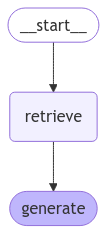

In [17]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

LangGraph is not required to build a RAG application. Indeed, we can implement the same application logic through invocations of the individual components:

```py
question = "..."

retrieved_docs = vector_store.similarity_search(question)
docs_content = "\n\n".join(doc.page_content for doc in retrieved_docs)
prompt = prompt.invoke({"question": question, "context": docs_content})
answer = llm.invoke(prompt)
```

The benefits of LangGraph include:

* Support for multiple invocation modes: this logic would need to be rewritten if we wanted to stream output tokens, or stream the results of individual steps;
* Automatic support for tracing via LangSmith and deployments via LangGraph Platform;
* Support for persistence, human-in-the-loop, and other features.

Many use-cases demand RAG in a conversational experience, such that a user can receive context-informed answers via a stateful conversation. As we will see in Part 2 of the tutorial, LangGraph's management and persistence of state simplifies these applications enormously.

#### **Usage**

Let's test our application! LangGraph supports multiple invocation modes, including sync, async, and streaming.

##### **Invoke:**

In [34]:
# recursive splitter 

result = graph.invoke({"question": "what is the dress code?"})

print(f'Context: {result["context"]}\n\n')
print(f'Answer: {result["answer"]}')

Context: [Document(id='cfdd9280-a3e3-4132-817b-fa2a58b9f382', metadata={'author': 'Steven Overby', 'creationdate': '2021-07-20T13:27:27-04:00', 'creator': 'Microsoft® Word 2019', 'moddate': '2021-07-20T13:27:27-04:00', 'page': 21, 'page_label': '22', 'producer': 'Microsoft® Word 2019', 'source': '../mcdHandbook.pdf', 'start_index': 0, 'total_pages': 40}, page_content='22 Updated July, 2021  \nA&A Management/ Goodwin Partners  d/b/a McDonald’s \n  \ngrey; no pink, purple, blue, vivid orange, vivid reds, etc.) Hats are the only acceptable \nheadgear. The appropriate McDonald’s hat – visor must be worn. \n6. Pants must be worn around the waist. \n7. Solid Black (no stripes, lines, other colors), rubber soled non-slip is the only appropriate \nfootwear. No tennis shoes or other type of athletic footwear – shoes must be low-heeled, \ncomfortable and polish able. \n8. Men: The only permissible facial hair will be trimmed mustache and/or short/small \ngoatee that is neatly groomed and/or bear

In [ ]:
# parent child splitter

result = graph.invoke({"question": "what is the dress code?"})

print(f'Context: {result["context"]}\n\n')
print(f'Answer: {result["answer"]}')

Context: [Document(metadata={'producer': 'Microsoft® Word 2019', 'creator': 'Microsoft® Word 2019', 'creationdate': '2021-07-20T13:27:27-04:00', 'author': 'Steven Overby', 'moddate': '2021-07-20T13:27:27-04:00', 'source': '../mcdHandbook.pdf', 'total_pages': 40, 'page': 21, 'page_label': '22'}, page_content='22 Updated July, 2021  \nA&A Management/ Goodwin Partners  d/b/a McDonald’s \n  \ngrey; no pink, purple, blue, vivid orange, vivid reds, etc.) Hats are the only acceptable \nheadgear. The appropriate McDonald’s hat – visor must be worn. \n6. Pants must be worn around the waist. \n7. Solid Black (no stripes, lines, other colors), rubber soled non-slip is the only appropriate \nfootwear. No tennis shoes or other type of athletic footwear – shoes must be low-heeled, \ncomfortable and polish able. \n8. Men: The only permissible facial hair will be trimmed mustache and/or short/small \ngoatee that is neatly groomed and/or beard that is small and neatly groomed. The goatee \nand/or beard

In [ ]:
result = graph.invoke({"question": "How were Nike's margins impacted in 2023?"})

print(f'Context: {result["context"]}\n\n')
print(f'Answer: {result["answer"]}')

Context: [Document(id='6f4a4d04-4924-4a51-947d-6e1c49d534c5', metadata={'author': 'EDGAR Online, a division of Donnelley Financial Solutions', 'creationdate': '2023-07-20T16:22:00-04:00', 'creator': 'EDGAR Filing HTML Converter', 'keywords': '0000320187-23-000039; ; 10-K', 'moddate': '2023-07-20T16:22:08-04:00', 'page': 42, 'page_label': '43', 'producer': 'EDGRpdf Service w/ EO.Pdf 22.0.40.0', 'section': 'middle', 'source': '../nke-10k-2023.pdf', 'start_index': 2886, 'subject': 'Form 10-K filed on 2023-07-20 for the period ending 2023-05-31', 'title': '0000320187-23-000039', 'total_pages': 107}, page_content='• Gross margin contraction of approximately 190 basis points primarily due to higher product costs, reflecting product mix and higher input costs, as well as\nunfavorable changes in standard foreign currency exchange rates. This was partially offset by higher full-price ASP, net of discounts, due to product mix and strategic\npricing actions.\n• Selling and administrative expense 

##### **Stream Steps:**

In [21]:
for step in graph.stream(
    {"question": "How were Nike's margins impacted in 2023?"}, stream_mode="updates"
):
    print(f"{step}\n\n----------------\n")

{'retrieve': {'context': [Document(id='07ddd008-2b8d-4b4f-a802-de543a859480', metadata={'author': 'EDGAR Online, a division of Donnelley Financial Solutions', 'creationdate': '2023-07-20T16:22:00-04:00', 'creator': 'EDGAR Filing HTML Converter', 'keywords': '0000320187-23-000039; ; 10-K', 'moddate': '2023-07-20T16:22:08-04:00', 'page': 42, 'page_label': '43', 'producer': 'EDGRpdf Service w/ EO.Pdf 22.0.40.0', 'source': '../nke-10k-2023.pdf', 'start_index': 2886, 'subject': 'Form 10-K filed on 2023-07-20 for the period ending 2023-05-31', 'title': '0000320187-23-000039', 'total_pages': 107}, page_content='• Gross margin contraction of approximately 190 basis points primarily due to higher product costs, reflecting product mix and higher input costs, as well as\nunfavorable changes in standard foreign currency exchange rates. This was partially offset by higher full-price ASP, net of discounts, due to product mix and strategic\npricing actions.\n• Selling and administrative expense incre

##### **Stream Tokens:**

In [22]:
for message, metadata in graph.stream(
    {"question": "How were Nike's margins impacted in 2023?"}, stream_mode="messages"
):
    print(message.content, end="|")

Nike|'s gross margin decreased by 250 basis points to 43|.5% in fiscal year 2023, primarily due to higher| product costs, unfavorable currency exchange rates, and lower off-price margins.  This was partially offset by higher full-price average selling prices.|

For async invocations, use:

```py
result = await graph.ainvoke(...)
```

and

```py
async for step in graph.astream(...):
```

**Returning sources**

Note that by storing the retrieved context in the state of the graph, we recover sources for the model's generated answer in the ```"context"``` field of the state. See this guide on returning sources for more detail.

#### **Customizing the prompt**

As shown above, we can load prompts (e.g., this RAG prompt) from the prompt hub. The prompt can also be easily customized. For example: (local)

In [23]:
from langchain_core.prompts import PromptTemplate

template = """Use the following pieces of context to answer the question at the end.
If you don't know the answer, just say that you don't know, don't try to make up an answer.
Use three sentences maximum and keep the answer as concise as possible.
Always say "thanks for asking!" at the end of the answer.

{context}

Question: {question}

Helpful Answer:"""
custom_rag_prompt = PromptTemplate.from_template(template)

#### **Query Analysis**

So far, we are executing the retrieval using the raw input query. However, there are some advantages to allowing a model to generate the query for retrieval purposes. For example:

* In addition to semantic search, we can build in structured filters (e.g., "Find documents since the year 2020.");
* The model can rewrite user queries, which may be multifaceted or include irrelevant language, into more effective search queries.

Query analysis employs models to transform or construct optimized search queries from raw user input. We can easily incorporate a query analysis step into our application. For illustrative purposes, let's add some metadata to the documents in our vector store. We will add some (contrived) sections to the document which we can filter on later.

In [8]:
total_documents = len(all_splits)
third = total_documents // 3

for i, document in enumerate(all_splits):
    if i < third:
        document.metadata["section"] = "beginning"
    elif i < 2 * third:
        document.metadata["section"] = "middle"
    else:
        document.metadata["section"] = "end"


all_splits[0].metadata

{'producer': 'EDGRpdf Service w/ EO.Pdf 22.0.40.0',
 'creator': 'EDGAR Filing HTML Converter',
 'creationdate': '2023-07-20T16:22:00-04:00',
 'title': '0000320187-23-000039',
 'author': 'EDGAR Online, a division of Donnelley Financial Solutions',
 'subject': 'Form 10-K filed on 2023-07-20 for the period ending 2023-05-31',
 'keywords': '0000320187-23-000039; ; 10-K',
 'moddate': '2023-07-20T16:22:08-04:00',
 'source': '../nke-10k-2023.pdf',
 'total_pages': 107,
 'page': 0,
 'page_label': '1',
 'start_index': 0,
 'section': 'beginning'}

In [9]:
all_splits[2]

Document(metadata={'producer': 'EDGRpdf Service w/ EO.Pdf 22.0.40.0', 'creator': 'EDGAR Filing HTML Converter', 'creationdate': '2023-07-20T16:22:00-04:00', 'title': '0000320187-23-000039', 'author': 'EDGAR Online, a division of Donnelley Financial Solutions', 'subject': 'Form 10-K filed on 2023-07-20 for the period ending 2023-05-31', 'keywords': '0000320187-23-000039; ; 10-K', 'moddate': '2023-07-20T16:22:08-04:00', 'source': '../nke-10k-2023.pdf', 'total_pages': 107, 'page': 0, 'page_label': '1', 'start_index': 1592, 'section': 'beginning'}, page_content='past 90 days.\nþ ¨ \n• whether the registrant has submitted electronically every Interactive Data File required to be submitted pursuant to Rule 405 of Regulation S-T\n(§232.405 of this chapter) during the preceding 12 months (or for such shorter period that the registrant was required to submit such files).\nþ ¨ \n• whether the registrant is a large accelerated filer, an accelerated filer, a non-accelerated filer, a smaller report

We will need to ```update``` the documents in our vector store. We will use a simple InMemoryVectorStore for this, as we will use some of its specific features (i.e., ```metadata filtering```). Refer to the vector store integration documentation for relevant features of your chosen vector store.

```py
from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)
_ = vector_store.add_documents(all_splits)
```

In [10]:
# will utilize chroma for now
# remove the old one and re add documents

# from chromadb import PersistentClient

# # Initialize the client with the persistence directory
# client = PersistentClient(path="./chroma_langchain_db")

# # Delete the specific collection by name
# # client.delete_collection(name="example_collection")
# client.delete_collection(name="nike_collection")

ids = vector_store.add_documents(documents=all_splits)

Let's next define a schema for our search query. We will use structured output for this purpose. Here we define a query as containing a string query and a document section (either "beginning", "middle", or "end"), but this can be defined however you like.

In [31]:
from typing import Literal

from typing_extensions import Annotated
from langchain_core.documents import Document
from typing_extensions import List, TypedDict
from pydantic import BaseModel, Field


#modify as it gives signature at runtime error
class Search(BaseModel):
    """Search query model."""
    query: str = Field(..., description="Search query to run.")
    section: Literal["beginning", "middle", "end"] = Field(..., description="Section to query.")

Finally, we add a step to our LangGraph application to generate a query from the user's raw input:

***Updated Code***

In [ ]:
from langgraph.graph import START, StateGraph


class State(TypedDict):
    question: str
    query: Search #newly added
    context: List[Document]
    answer: str


#newly added
def analyze_query(state: State):
    structured_llm = llm.with_structured_output(Search)
    query = structured_llm.invoke(state["question"])
    return {"query": query}


def retrieve(state: State):
    query = state["query"] #newly added
    retrieved_docs = vector_store.similarity_search(
        query.query, #from query["query"] become query.query as it got not subscripable error
        # filter=lambda doc: doc.metadata.get("section") == query["section"],
        filter={"section": query.section}, # for chroma modify like this, and query.section to solve not subscripable error
    ) #newly added
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}


graph_builder = StateGraph(State).add_sequence([analyze_query, retrieve, generate]) #modified
graph_builder.add_edge(START, "analyze_query") #modified
graph = graph_builder.compile()

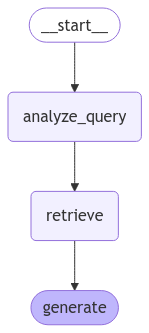

In [33]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

We can test our implementation by specifically asking for context from the end of the post. Note that the model includes different information in its answer.

In [48]:
for step in graph.stream(
    {"question": "what does the middle of report says about margin"},
    stream_mode="updates",
):
    print(f"{step}\n\n----------------\n")

{'analyze_query': {'query': Search(query='margin', section='middle')}}

----------------

{'retrieve': {'context': [Document(id='fc6b9000-3400-4bbc-a284-85472585a561', metadata={'author': 'EDGAR Online, a division of Donnelley Financial Solutions', 'creationdate': '2023-07-20T16:22:00-04:00', 'creator': 'EDGAR Filing HTML Converter', 'keywords': '0000320187-23-000039; ; 10-K', 'moddate': '2023-07-20T16:22:08-04:00', 'page': 49, 'page_label': '50', 'producer': 'EDGRpdf Service w/ EO.Pdf 22.0.40.0', 'section': 'middle', 'source': '../nke-10k-2023.pdf', 'start_index': 2279, 'subject': 'Form 10-K filed on 2023-07-20 for the period ending 2023-05-31', 'title': '0000320187-23-000039', 'total_pages': 107}, page_content='different than reserves established, a reduction or increase to net revenues would be recorded in the period in which such determination was made.\nRefer to Note 14 — Revenues in the accompanying Notes to the Consolidated Financial Statements for additional information.\nINVEN

#### **Different Chunking Method**